# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult

In [85]:
from sklearn.metrics import mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import mean_squared_error 

from sklearn.linear_model import LinearRegression, Lasso

from scipy.stats import randint, uniform

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [7]:
url = "https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv"

In [8]:
#Loading the data
import requests
import io

s=requests.get(url).content
data = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [9]:
data.head(5)

,original_title,title,popularity,release_date,duration_min,description,budget,revenue,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,12314651.0,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,95149435.0,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,13092000.0,en,Released,97,145,0,Drama,United States of America,0,True
3,Kahaani,Kahaani,3.174936,2012-03-09,122.0,A pregnant woman's search for her missing husb...,1200000,16000000.0,hi,Released,23,18,0,"Drama, Thriller",India,0,True
4,The Possession,The Possession,7.286477,2012-08-30,92.0,A young girl buys an antique box at a yard sal...,14000000,85446075.0,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True


In [10]:
# YOUR CODE HERE
data.shape

(6864, 17)

In [11]:
#Droping duplicated rows
data = data.drop_duplicates()

In [12]:
data.shape

(6464, 17)

In [13]:
#Checking null values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6464 entries, 0 to 6463
Data columns (total 17 columns):
original_title               6464 non-null object
title                        6463 non-null object
popularity                   6464 non-null float64
release_date                 6464 non-null object
duration_min                 6464 non-null float64
description                  6464 non-null object
budget                       6464 non-null int64
revenue                      2617 non-null float64
original_language            6464 non-null object
status                       6464 non-null object
number_of_awards_won         6464 non-null int64
number_of_nominations        6464 non-null int64
has_collection               6464 non-null int64
all_genres                   6464 non-null object
top_countries                6464 non-null object
number_of_top_productions    6464 non-null int64
available_in_english         6464 non-null bool
dtypes: bool(1), float64(3), int64(5), object(8

In [14]:
data.isnull().sum().sort_values(ascending=False)

revenue                      3847
title                           1
available_in_english            0
popularity                      0
release_date                    0
duration_min                    0
description                     0
budget                          0
original_language               0
number_of_top_productions       0
status                          0
number_of_awards_won            0
number_of_nominations           0
has_collection                  0
all_genres                      0
top_countries                   0
original_title                  0
dtype: int64

In [15]:
#Mask to drop the rows without title
data = data[~data.title.isnull()]

In [16]:
data.shape

(6463, 17)

In [17]:
#Droping columns with missing value
data = data.drop(['revenue'], axis = 1)

In [18]:
data.shape

(6463, 16)

### 🧪 Run the following cell to save your results

In [19]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

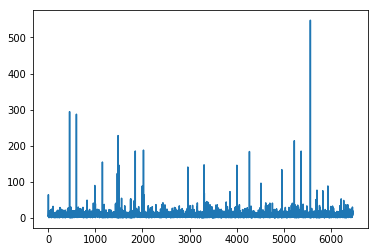

In [20]:
data.popularity.plot()

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

In [21]:
# YOUR CODE HERE
scoring = "neg_mean_squared_log_error"

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [22]:
# YOUR CODE HERE
X = data.copy().drop(columns=['popularity'])

In [23]:
#The target is the popularity
y = data.copy().popularity

In [24]:
print(X.shape, y.shape)

(6463, 15) (6463,)


### Basic pipeline

📝 **Check unique values per features**

In [25]:
# YOUR CODE HERE
X.nunique()

original_title               6350
title                        6337
release_date                 4320
duration_min                  152
description                  6449
budget                        636
original_language              42
status                          3
number_of_awards_won          124
number_of_nominations         180
has_collection                  2
all_genres                    745
top_countries                 320
number_of_top_productions       5
available_in_english            2
dtype: int64

In [26]:
#We have a lot of movies with no-budget (or no info on budget)
#X[cols[5]].value_counts()
X.budget.value_counts().head(5)

0           1424
20000000     184
25000000     171
15000000     169
30000000     154
Name: budget, dtype: int64

In [27]:
X.has_collection.value_counts()

0    5072
1    1391
Name: has_collection, dtype: int64

In [28]:
X.number_of_top_productions.value_counts().head(5)

1    3050
0    2883
2     457
3      69
4       4
Name: number_of_top_productions, dtype: int64

In this baseline, let's forget about the columns below that are difficult to process

In [29]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

In [30]:
#Checking which columns need to be scaled
X.describe()

,duration_min,budget,number_of_awards_won,number_of_nominations,has_collection,number_of_top_productions
count,6463.000000,6.463000e+03,6463.000000,6463.000000,6463.000000,6463.000000
mean,109.232864,2.566380e+07,6.785549,12.796070,0.215225,0.647842
std,20.402763,3.857318e+07,16.214263,25.483955,0.411010,0.664165
min,59.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,95.000000,6.000000e+05,0.000000,1.000000,0.000000,0.000000
50%,105.000000,1.100000e+07,2.000000,5.000000,0.000000,1.000000
75%,119.000000,3.262265e+07,6.000000,13.000000,0.000000,1.000000
max,320.000000,3.800000e+08,245.000000,336.000000,1.000000,4.000000


We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [31]:
numerical = ['duration_min', 'budget', 'number_of_awards_won',
             'has_collection','number_of_top_productions','number_of_nominations']
categorical = ['original_language', 'status', 'all_genres', 
               'top_countries', 'available_in_english']

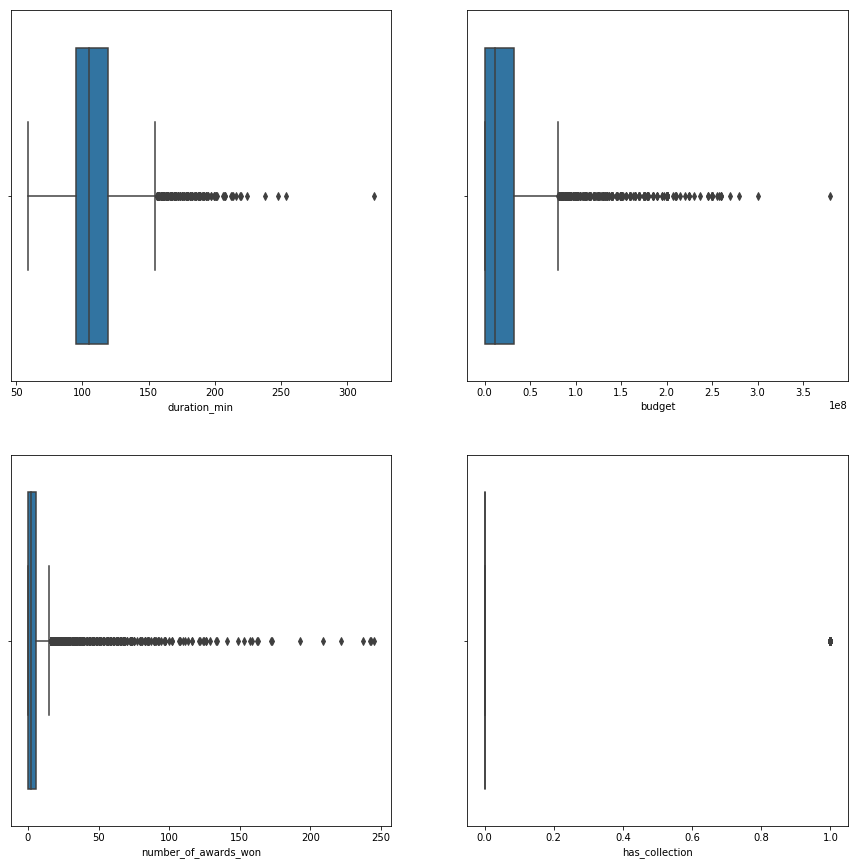

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for feature_name, ax in zip(numerical, axes.flatten()):
    sns.boxplot(X[feature_name], ax=ax)

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

In [33]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')

In [34]:
categorical

['original_language',
 'status',
 'all_genres',
 'top_countries',
 'available_in_english']

In [35]:
# YOUR CODE HERE
#Creating the preprocessor, composed of pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numerical_preproc = Pipeline([('Robust_Scaler', RobustScaler())])

categorical_preproc = OneHotEncoder(handle_unknown='ignore',sparse=False)

In [36]:

basic_preprocessing = ColumnTransformer(
    transformers=[
        # Dropping columns that will not be used by the model
        ('drop_date_and_text', 'drop', ['description', 'original_title', 'title', 'release_date']),
        
        # Scaling continuous features with outliers
        ('numercial_preproc', numerical_preproc, numerical),
        
        # One-hot encoding the categorical and boolean features 
        ('categorical_preproc', categorical_preproc, categorical),],
    sparse_threshold=0
)

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [37]:
basic_preprocessing.fit(X)
X_basic_preprocessing=pd.DataFrame(basic_preprocessing.transform(X))

In [38]:
X_basic_preprocessing.shape[1]

1118

In [39]:
X_basic_preprocessing.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117
0,-0.500000,0.093684,-0.333333,1.0,2.0,-0.250000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.333333,0.905609,-0.166667,1.0,0.0,-0.250000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,-0.240455,15.833333,0.0,-1.0,11.666667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.708333,-0.306033,3.500000,0.0,-1.0,1.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.541667,0.093684,-0.333333,0.0,-1.0,0.083333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


**❓ How many features has been generated by the preprocessing? What do you think about this number?**

> 1118

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [40]:
l1_reg = Lasso()

basic_pipeline = make_pipeline(basic_preprocessing, l1_reg)

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [41]:
from sklearn.model_selection import cross_val_score

In [42]:
basic_scores = cross_val_score(basic_pipeline, X, y, cv=10, 
                               scoring=scoring)
basic_scores

array([-0.3277482 , -0.27245511, -0.34489363, -0.29840924, -0.27490114,
       -0.3497206 , -0.30355503, -0.30098822, -0.34610956, -0.31929733])

### 🧪 Save your results

Run the following cell to save your results

In [43]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [44]:
X = data.copy().drop(columns=['popularity','description', 'original_title', 'title'])

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    #Class constructor method that takes in a list of values as its argument
    def fit(self, X, y=None):
        return self

    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = pd.DataFrame()
        X['release_date']= pd.to_datetime(X['release_date'])
        df['month'] = X['release_date'].dt.month
        df['year'] = X['release_date'].dt.year
        return df

In [46]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

C:\Users\mvalyashova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,month,year
0,2,2015
1,8,2004
2,10,2014
3,3,2012
4,8,2012


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        
        self.month_cos = np.cos(2 * np.pi * X_time_features['month']/12)
        self.month_sin = np.sin(2 * np.pi * X_time_features['month']/12)
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """

        year_preproc = Pipeline([('scaler', MinMaxScaler())])
        preproc = ColumnTransformer([('year_preproc', year_preproc, ['year'])])
        X_time_features['year']= preproc.fit_transform(X_time_features[['year']])
        
        X_time_features['month_cos'] = self.month_cos
        X_time_features['month_sin'] = self.month_sin
        return pd.DataFrame(X_time_features)

In [48]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

,month,year,month_cos,month_sin
0,2,0.979167,5.000000e-01,0.866025
1,8,0.864583,-5.000000e-01,-0.866025
2,10,0.968750,5.000000e-01,-0.866025
3,3,0.947917,6.123234e-17,1.000000
4,8,0.947917,-5.000000e-01,-0.866025


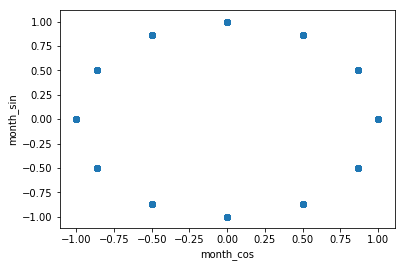

In [49]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [50]:
# YOUR CODE HERE
new_preprocessor = ColumnTransformer([
    ('numercial_preproc', numerical_preproc, numerical),
    ('categorical_preproc', categorical_preproc, categorical),
    ('time_scaler', TimeFeaturesExtractor(),['release_date']),
    #('cyclical_scaler', CyclicalEncoder(), 'release_date')
],remainder='passthrough')

new_preprocessor.fit(X)
X_new_preprocessing=pd.DataFrame(new_preprocessor.transform(X))

In [51]:
X_new_preprocessing.shape[1]

1120

In [52]:
time_pipeline = Pipeline([
    ('preprocessor', new_preprocessor),
    ('model', Lasso())
])

In [53]:
print(X_new_preprocessing.loc[[598]])

     0         1         2     3     4     5     6     7     8     9     \
598  -1.0 -0.303816  0.333333   0.0   0.0  0.25   0.0   0.0   0.0   0.0   

      ...    1110  1111  1112  1113  1114  1115  1116  1117  1118    1119  
598   ...     0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   1.0  1955.0  

[1 rows x 1120 columns]


In [54]:
time_scores = cross_val_score(time_pipeline, X, y, cv=5, scoring=scoring).mean()
time_scores

-0.3150099514044973

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [55]:
X[['all_genres', 'top_countries']].nunique()

all_genres       745
top_countries    320
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [56]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
6459,Thriller,"France, United States of America"
6460,"Action, Adventure, Comedy, Thriller",United States of America
6461,Drama,United States of America
6462,"Horror, Thriller",United States of America
6463,Drama,France


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [57]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [58]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(6463, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,genre_Science Fiction,genre_Horror,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [59]:
# YOUR CODE HERE
new_preprocessor1 = ColumnTransformer([
    ('numercial_preproc', numerical_preproc, numerical),
    ('categorical_preproc', categorical_preproc, ['original_language', 'status', 'has_collection','number_of_top_productions','available_in_english']),
    ('time_scaler', TimeFeaturesExtractor(),['release_date']),
    #('cyclical_scaler', CyclicalEncoder(), ['release_date']),
    ('custom_scaler',CustomGenreAndCountryEncoder(),['all_genres', 'top_countries'])],remainder='passthrough')

new_preprocessor1.fit(X)
X_final_preprocessing=pd.DataFrame(new_preprocessor1.transform(X))

In [60]:
X_final_preprocessing.shape[1]

77

In [61]:
final_pipeline = Pipeline([
    ('preprocessor', new_preprocessor1),
    ('model', Lasso())
])

In [62]:
final_scores = cross_val_score(final_pipeline, X, y, cv=5, scoring=scoring)
final_scores

array([-0.30326295, -0.32181505, -0.31676315, -0.3025935 , -0.3306151 ])

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

### 🧪 Save your result

Run the following cell to save your results.

In [63]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [77]:
from sklearn.ensemble import RandomForestRegressor
rf_pipeline = make_pipeline(new_preprocessor1, RandomForestRegressor(criterion='mse'))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numercial_preproc',
                                                  Pipeline(steps=[('Robust_Scaler',
                                                                   RobustScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'has_collection',
                                                   'number_of_top_productions',
                                                   'number_of_nominations']),
                                                 ('categorical_preproc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['original_language',
                                                   'status', 'has_collection',
                                                   'number_of_top_productions',
                                                   'available_in_english']),
                                                 ('time_scaler',
                                                  TimeFeaturesExtractor(),
                                                  ['release_date']),
                                                 ('custom_scaler',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [80]:
cv_result_3 = cross_validate(rf_pipeline,
                           X, y,
                           cv = 10,
                           scoring = scoring,
                           n_jobs=-1)

In [81]:
rf_scores = cv_result_3['test_score']
rf_scores

array([-0.26352166, -0.22706481, -0.24685018, -0.22741496, -0.21914078,
       -0.26550459, -0.21933421, -0.24576231, -0.24955441, -0.24311169])

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [66]:
# YOUR CODE HERE
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(
    final_pipeline_rf, 
    param_grid={
        'model__min_samples_split': [20], #[1,2,10]
        'model__max_depth': [8]},#[4,8,16] [6, 8, 10]
    cv=5,
    scoring=scoring)
search.fit(X,y);
search.best_params_ , search.best_score_

({'model__max_depth': 8, 'model__min_samples_split': 20}, -0.25513415622350477)

In [76]:
search = RandomForestRegressor(max_depth=50,min_samples_leaf=20)

In [84]:
# Coarse tuning 
grid = {'randomforestregressor__n_estimators' : np.arange(100,301, 100),
    'randomforestregressor__max_depth' : np.arange(2,101, 20)}

search = GridSearchCV(rf_pipeline, grid,
                           scoring = scoring,
                           cv = 5,
                           n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numercial_preproc',
                                                                         Pipeline(steps=[('Robust_Scaler',
                                                                                          RobustScaler())]),
                                                                         ['duration_min',
                                                                          'budget',
                                                                          'number_of_awards_won',
                                                                          'has_collection',
                                                                          'number_of_top_productions',
                                                                          'number_of_nominations']),
                                                                        ('categorical_preproc',
                                                                         OneHotEncoder(h...
                                                                         TimeFeaturesExtractor(),
                                                                         ['release_date']),
                                                                        ('custom_scaler',
                                                                         CustomGenreAndCountryEncoder(),
                                                                         ['all_genres',
                                                                          'top_countries'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': array([ 2, 22, 42, 62, 82]),
                         'randomforestregressor__n_estimators': array([100, 200, 300])},
             scoring='neg_mean_squared_log_error')

In [86]:
search.best_score_

-0.24011811363694324

In [87]:
search.best_params_

{'randomforestregressor__max_depth': 62,
 'randomforestregressor__n_estimators': 300}

In [89]:
# Fine tuning
grid = {'randomforestregressor__n_estimators' : [275, 300, 325],
    'randomforestregressor__max_depth' : np.arange(75,86, 2)}

search = RandomizedSearchCV(rf_pipeline, grid,
                           scoring = scoring,
                           cv = 5,
                           n_jobs=-1)
search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numercial_preproc',
                                                                               Pipeline(steps=[('Robust_Scaler',
                                                                                                RobustScaler())]),
                                                                               ['duration_min',
                                                                                'budget',
                                                                                'number_of_awards_won',
                                                                                'has_collection',
                                                                                'number_of_top_productions',
                                                                                'number_of_nominations']),
                                                                              ('categorical_preproc',
                                                                               OneHotEnc...
                                                                               TimeFeaturesExtractor(),
                                                                               ['release_date']),
                                                                              ('custom_scaler',
                                                                               CustomGenreAndCountryEncoder(),
                                                                               ['all_genres',
                                                                                'top_countries'])])),
                                             ('randomforestregressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__max_depth': array([75, 77, 79, 81, 83, 85]),
                                        'randomforestregressor__n_estimators': [275,
                                                                                300,
                                                                                325]},
                   scoring='neg_mean_squared_log_error')

In [90]:
search.best_params_ , search.best_score_

({'randomforestregressor__n_estimators': 325,
  'randomforestregressor__max_depth': 75},
 -0.2400932467565636)

In [93]:
rf_pipeline_search = make_pipeline(new_preprocessor1, RandomForestRegressor(criterion='mse', n_estimators = 325, max_depth = 79))
rf_pipeline_search

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numercial_preproc',
                                                  Pipeline(steps=[('Robust_Scaler',
                                                                   RobustScaler())]),
                                                  ['duration_min', 'budget',
                                                   'number_of_awards_won',
                                                   'has_collection',
                                                   'number_of_top_productions',
                                                   'number_of_nominations']),
                                                 ('categorical_preproc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['original_language',
                                                   'status', 'has_collection',
                                                   'number_of_top_productions',
                                                   'available_in_english']),
                                                 ('time_scaler',
                                                  TimeFeaturesExtractor(),
                                                  ['release_date']),
                                                 ('custom_scaler',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=79, n_estimators=325))])

In [95]:
cv_result_rf = cross_validate(rf_pipeline_search,
                           X, y,
                           cv = 10,
                           scoring = scoring,
                           n_jobs=-1)

best_scores = cv_result_rf['test_score']
best_scores

array([-0.26488776, -0.21645881, -0.24622146, -0.23107494, -0.21284332,
       -0.26688523, -0.21448091, -0.24327234, -0.24761399, -0.2392315 ])

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [96]:
# YOUR CODE HERE
# Print below your best pipe for correction purpose
final_pipe_trained = rf_pipeline_search.fit(X,y)

best_pipeline = final_pipe_trained

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [97]:
cars = {'release_date': ['2017-05-02'],
        'duration_min': [50],
        'budget': [3000000],
        'original_language':["es"],
        'status': ["Released"],
        'number_of_awards_won': [2],
        'number_of_nominations': [5],
        'has_collection': [1],
        'all_genres': ["Action, Crime, Mystery"],
        'top_countries': ["Spain, France, United States of America"],
        'number_of_top_productions': [1],
        'available_in_english': ['True']                 
        }

df = pd.DataFrame(cars, columns = ['release_date', 'duration_min','budget', 'original_language','status',
                                   'number_of_awards_won', 'number_of_nominations','has_collection','all_genres',
                                   'top_countries','number_of_top_productions','available_in_english'
                                  ])

In [98]:
# Make predictions
popularity = best_pipeline.predict(df.iloc[0:2])

In [99]:
popularity

array([13.01745202])

In [ ]:
# YOUR CODE HERE

### 🧪 Save your results

Run the following cell to save your results.

In [100]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**